### Conditional GAN

#### References
- [CGAN in Keras](https://keras.io/examples/generative/conditional_gan/)
- [Advanced-Deep-Learning-with-Python/Chapter05](https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Python/blob/master/Chapter05/dcgan.ipynb)

<a href="https://colab.research.google.com/github/paulaceccon/deep-learning-studies/blob/main/notebooks/generative_models/gans/cgan.ipynb" target="_parent" style="float: left;"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Flatten,
    Input,
    LeakyReLU,
    Reshape,
    GlobalMaxPooling2D
)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential

%load_ext tensorboard

### Load the dataset

In [2]:
def preprocess(data: np.array) -> np.ndarray:
    data = (data.astype("float32")) / 255.0
    data = np.reshape(data, (len(data), 28, 28, 1))
    return data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.concatenate([x_train, x_test])
y_train = np.concatenate([y_train, y_test])
x_train = preprocess(x_train)
y_train = to_categorical(y_train, 10)

print(x_train.shape)

(70000, 28, 28, 1)


### Visualization

In [4]:
def plot_generated_images(generator: Model, label: int) -> None:
    # Display a 2D manifold of the digits
    n = 10
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    # n*n random latent distributions
    noise = np.random.normal(0, 1, (n * n, latent_dim))
    one_hot_label = to_categorical([label], num_labels)
    one_hot_label = tf.repeat(one_hot_label, repeats=[n * n])
    one_hot_label = tf.reshape(
            one_hot_label, (n*n, num_labels)
        )
    
    random_vector_labels = tf.concat([noise, one_hot_label], axis=1)

    generated_images = generator.predict(random_vector_labels)
    for i in range(n):
        for j in range(n):
            slice_i = slice(i * digit_size, (i + 1) * digit_size)
            slice_j = slice(j * digit_size, (j + 1) * digit_size)
            figure[slice_i, slice_j] = np.reshape(generated_images[i * n + j], (28, 28))

    plt.figure(num=label, figsize=(10, 10))
    plt.axis('off')
    plt.imshow(figure, cmap='Greys_r')

### Model

In [5]:
def build_generator(latent_dim: int = 256, num_labels: int = 10) -> Model:
    """
    Produces 28x28 images.
    """
    generator_in_dims = latent_dim + num_labels
    generator = Sequential(
    [
        Input((generator_in_dims,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        Dense(7 * 7 * generator_in_dims),
        LeakyReLU(alpha=0.2),
        Reshape((7, 7, generator_in_dims)),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
    )
    generator.summary()

    return generator

In [6]:
def build_discriminator(num_labels: int = 10) -> Model:
    """
    Classifies images as real or fake.
    """
    discriminator_in_dims = 1 + num_labels  # 1 as B&W images
    discriminator = Sequential(
      [
          Input(shape=(28, 28, discriminator_in_dims)),
          Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
          LeakyReLU(alpha=0.2),
          Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
          LeakyReLU(alpha=0.2),
          GlobalMaxPooling2D(),
          Dense(1),
      ],
      name="discriminator",
    )
    discriminator.summary()

    return discriminator

In [7]:
class CGAN(Model):
    """Implements a conditional GAN."""

    def __init__(self, generator: Model, discriminator: Model, latent_dim: int,  image_size: int, num_labels: int):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.image_size = image_size
        self.num_labels = num_labels

    def compile(self, d_optimizer, g_optimizer, loss_fn) -> None:
        """
        Compile the model.

        Args:
            d_optimizer: discriminator's optimizer.
            g_optimizer: generator's optimizer.
            loss_fn: loss function.
        """
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = Mean(name="d_loss")
        self.g_loss_metric = Mean(name="g_loss")     

    @property
    def metrics(self) -> list:
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data) -> dict:
        real_images, one_hot_labels = data
        # 1. Train the discriminator
        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[self.image_size * self.image_size])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, self.image_size, self.image_size, self.num_labels))

        # Sample random points in the latent space,
        # concatenate the labels and decode them to fake images
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images
        # and create labels
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 2. Train the generator
        # Sample random points in the latent space
        # and a ssemble labels that say "all real images"
        # (note that we should *not* update the weights of the discriminator)!
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # 3. Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

### Training

In [8]:
latent_dim = 128
image_size = 28
num_labels = 10

def train_model(train_data: np.ndarray) -> tuple:
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

    discriminator = build_discriminator()
    generator = build_generator(latent_dim=latent_dim)
    gan = CGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, image_size=image_size, num_labels=num_labels)
    gan.compile(
        d_optimizer=Adam(learning_rate=0.0001),
        g_optimizer=Adam(learning_rate=0.0001),
        loss_fn=BinaryCrossentropy(from_logits=True),  
    )

    gan.fit(
        train_data,
        epochs=20,
        verbose=1,
        callbacks=[tensorboard_callback],
    )
    return gan, discriminator, generator

In [9]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 216), started 0:05:30 ago. (Use '!kill 216' to kill it.)

<IPython.core.display.Javascript object>

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(128)
_, _, generator = train_model(dataset)

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        6400      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                     

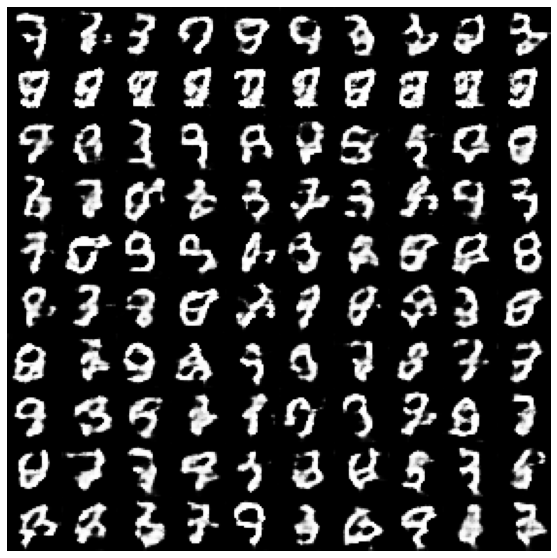

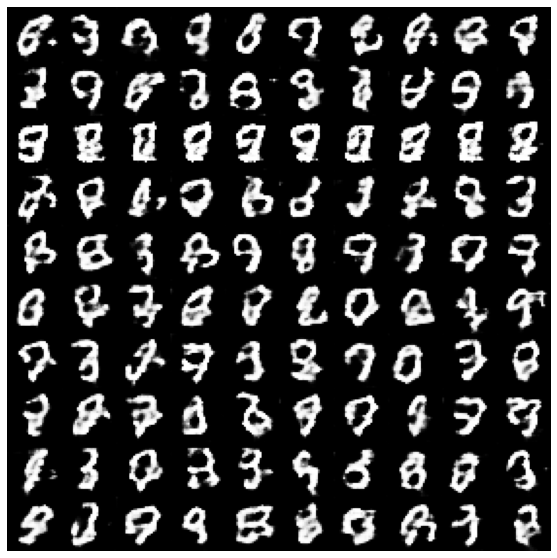

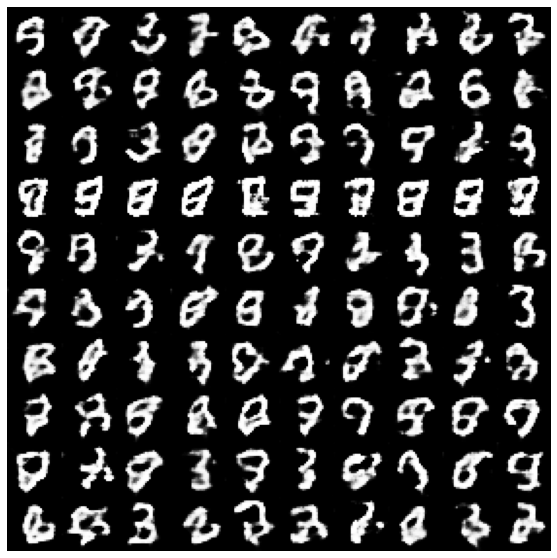

In [11]:
plot_generated_images(generator, 1)
plot_generated_images(generator, 2)
plot_generated_images(generator, 3)